# Precision Volatility Forecasting for Strategic Quote Placement in High-Frequency Trading

In [3]:
import os
import pandas as pd
import numpy as np
import random
import importlib

import models.util as util
importlib.reload(util)

<module 'models.util' from '/Users/kang/Projects/volatility-analysis/models/util.py'>

In [97]:
# Set path to local data directory
folder_path = "data"
feature_path = os.path.join(folder_path, "order_book_feature.parquet")
target_path = os.path.join(folder_path, "order_book_target.parquet")

# Load and combine parquet files
feature_df = pd.read_parquet(feature_path, engine='pyarrow')
target_df = pd.read_parquet(target_path, engine='pyarrow')
combined_df = pd.concat([feature_df, target_df], axis=0)
combined_df = combined_df.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)

# Load time reference
time_ref_path = os.path.join(folder_path, "time_id_reference.csv")
time_ref_df = pd.read_csv(time_ref_path)
time_ref_df["datetime"] = pd.to_datetime(time_ref_df["date"] + " " + time_ref_df["time"])

# Filter one stock for now
df_single_stock = combined_df[combined_df["stock_id"] == 50200].copy()

# Step 1: Compute snapshot features
snapshot_features_df = util.create_snapshot_features(df_single_stock)

# Step 2: Compute rolling-window training set
rolling_features_df = util.generate_rolling_features(snapshot_features_df)

# Merge time_id to datetime (optional for plotting/debugging)
rolling_features_df = pd.merge(
    rolling_features_df.drop(columns=["datetime"], errors="ignore"),
    time_ref_df[["time_id", "datetime"]],
    on="time_id",
    how="left"
)

# Preview
print("Rolling features:", rolling_features_df.shape)
display(rolling_features_df.head())

print("Rolling features:", snapshot_features_df.shape)
display(snapshot_features_df.head())

Rolling features: (833290, 25)


,stock_id,time_id,start_time,wap_mean,wap_std,wap_max,wap_min,spread_pct_mean,spread_pct_std,spread_pct_max,...,depth_ratio_mean,depth_ratio_std,depth_ratio_max,depth_ratio_min,log_return_mean,log_return_std,log_return_max,log_return_min,realized_volatility,datetime
0,50200.0,6.0,1800.0,372.347747,0.152688,372.598023,372.036666,0.000037,0.000013,0.000054,...,7.589939,44.479523,395.999604,0.033333,-0.000003,0.000046,0.000159,-0.000207,0.000235,NaT
1,50200.0,6.0,1802.0,372.340905,0.156816,372.598023,371.955111,0.000038,0.000013,0.000054,...,7.582752,44.480654,395.999604,0.033333,-0.000004,0.000048,0.000159,-0.000219,0.000356,NaT
2,50200.0,6.0,1805.0,372.332872,0.163290,372.598023,371.934998,0.000038,0.000013,0.000054,...,7.566621,44.482415,395.999604,0.033333,-0.000004,0.000048,0.000159,-0.000219,0.000357,NaT
3,50200.0,6.0,1807.0,372.326948,0.165921,372.598023,371.934998,0.000037,0.000013,0.000054,...,7.510483,44.485172,395.999604,0.033333,-0.000004,0.000051,0.000340,-0.000219,0.000162,NaT
4,50200.0,6.0,1810.0,372.319845,0.168082,372.598023,371.934998,0.000037,0.000013,0.000054,...,7.508179,44.485539,395.999604,0.033333,-0.000004,0.000050,0.000340,-0.000219,0.000179,NaT


Rolling features: (4166788, 18)


,stock_id,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,mid_price,wap,bid_ask_spread,spread_pct,imbalance,depth_ratio,log_return
27224315,50200,6,1800.0,372.48,372.50,372.47,372.51,200,200,1408,510,372.490,372.489999,0.02,0.000054,0.000000,1.000000,0.000000
27224316,50200,6,1800.0,372.48,372.50,372.47,372.51,200,200,1408,510,372.490,372.489999,0.02,0.000054,0.000000,1.000000,0.000000
27224317,50200,6,1801.0,372.47,372.48,372.46,372.49,435,830,608,300,372.475,372.473438,0.01,0.000027,-0.312253,0.524096,-0.000044
27224318,50200,6,1801.0,372.47,372.48,372.46,372.49,435,830,608,300,372.475,372.473438,0.01,0.000027,-0.312253,0.524096,0.000000
27224319,50200,6,1802.0,372.46,372.47,372.45,372.48,100,100,508,1500,372.465,372.464998,0.01,0.000027,0.000000,1.000000,-0.000023


=== HAR-RV Baseline Evaluation ===
MSE: 0.00000001
RMSE: 0.00010876
QLIKE: 0.6665
Directional Accuracy: 0.5070


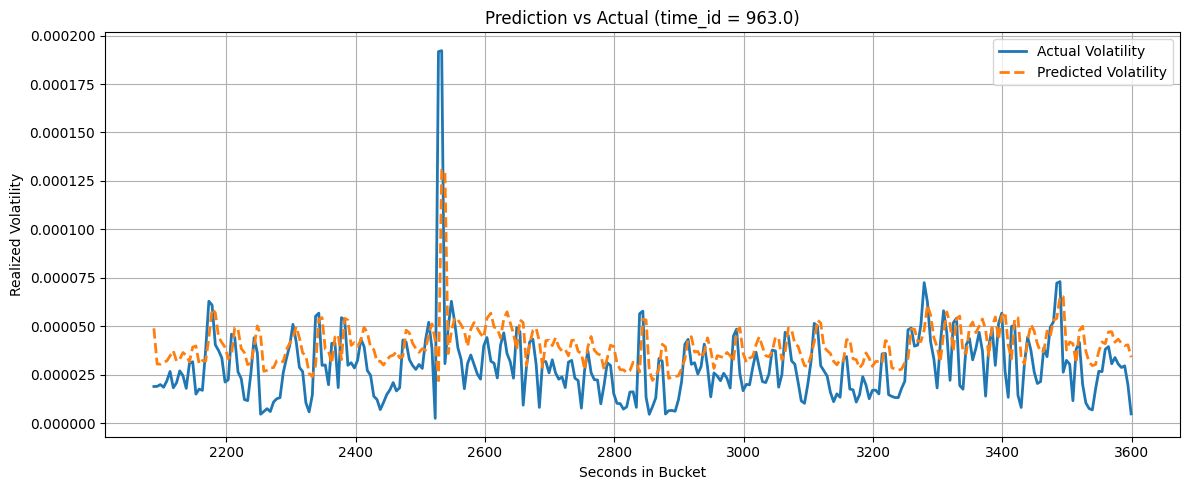

In [102]:
import models.har_rv as har_rv
importlib.reload(har_rv)

model_rv_ols, test_df_ols = har_rv.ols(rolling_features_df)

util.plot_prediction_vs_actual(
    df=test_df_ols,
    time_id=test_df_ols['time_id'].iloc[0],
    y_true_col='realized_volatility',
    y_pred_col='y_pred'
)

=== HAR-RV WLS Baseline Evaluation ===
MSE: 0.00000001
RMSE: 0.00011779
QLIKE: 0.8773
Directional Accuracy: 0.4819


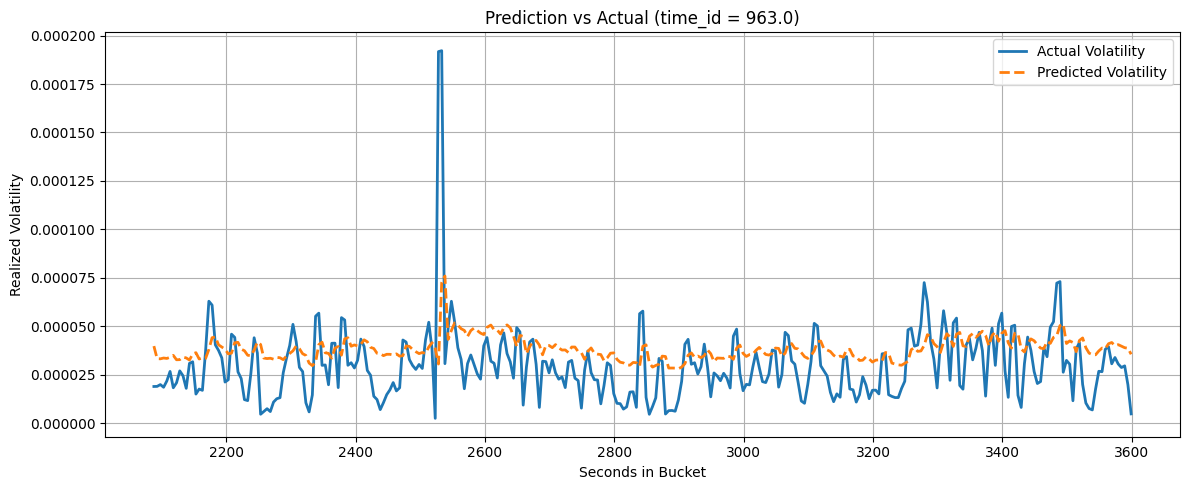

In [103]:
model_wls, test_df_wls = har_rv.wls(rolling_features_df)

util.plot_prediction_vs_actual(
    df=test_df_wls,
    time_id=test_df_wls['time_id'].iloc[0],
    y_true_col='realized_volatility',
    y_pred_col='y_pred'
)

In [ ]:
import models.lstm as lstm
importlib.reload(lstm)

subset_time_ids = snapshot_features_df['time_id'].unique()[:400]
df_subset = snapshot_features_df[snapshot_features_df['time_id'].isin(subset_time_ids)].copy()
lstm_df = util.generate_tick_sequences(df_subset, feature_cols=["wap","spread_pct","imbalance","depth_ratio","log_return"])

In [105]:
importlib.reload(lstm)
model_lstm_baseline, history_lstm_baseline, test_df_lstm_baseline = lstm.baseline(lstm_df)

Epoch 1/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 50s 30ms/step - loss: 0.7400 - val_loss: 0.8332 - learning_rate: 1.0000e-04
Epoch 2/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 48s 30ms/step - loss: 0.5534 - val_loss: 0.7962 - learning_rate: 1.0000e-04
Epoch 3/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 48s 30ms/step - loss: 0.5300 - val_loss: 0.7970 - learning_rate: 1.0000e-04
Epoch 4/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 48s 30ms/step - loss: 0.5369 - val_loss: 0.7419 - learning_rate: 1.0000e-04
Epoch 5/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 48s 30ms/step - loss: 0.5359 - val_loss: 0.7415 - learning_rate: 1.0000e-04
Epoch 6/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 49s 30ms/step - loss: 0.5459 - val_loss: 0.7784 - learning_rate: 1.0000e-04
Epoch 7/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 49s 30ms/step - loss: 0.5328 - val_loss: 0.7698 - learning_rate: 1.0000e-04
Epoch 8/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 48s 30ms/step - loss: 0.5057 - val_loss: 0.7525 - learning_rate: 1.0000e-04
Epoch 9/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 48s 30ms/step 

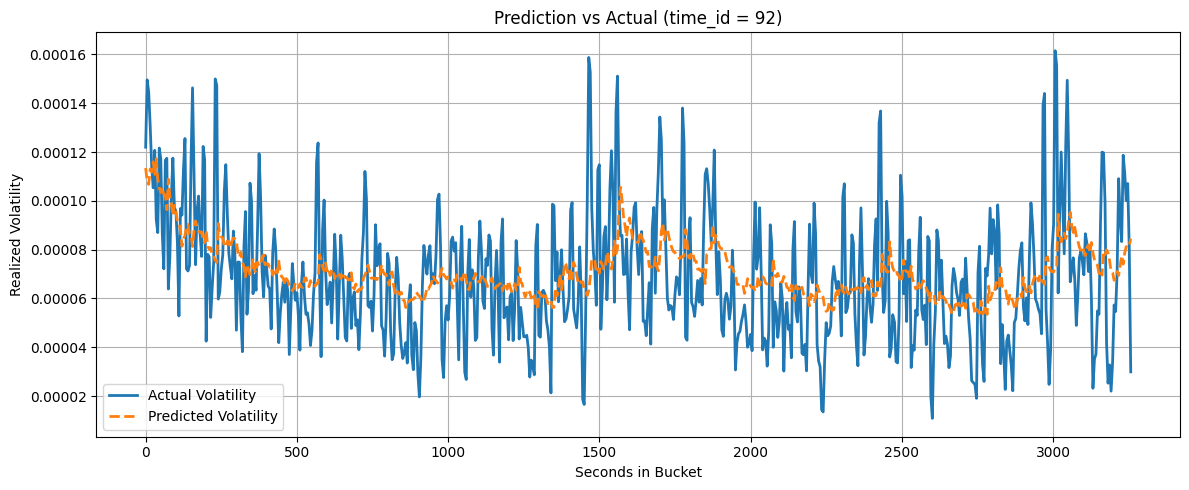

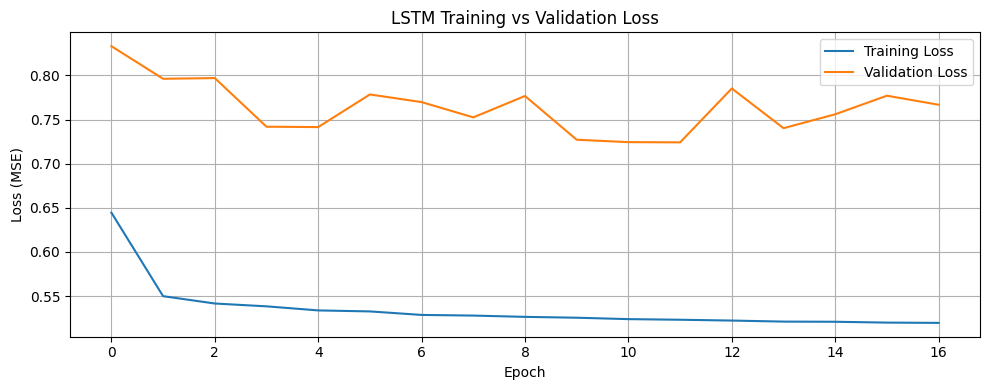

In [107]:
#test_df_lstm['time_id'].iloc[1]

util.plot_prediction_vs_actual(
    df=test_df_lstm_baseline,
    time_id=test_df_lstm_baseline['time_id'].iloc[1],
    y_true_col="y_true",
    y_pred_col="y_pred"
)

util.plot_training_loss(history_lstm_baseline)

In [10]:
model_lstm_v256d03, history_lstm_v256d03, test_df_lstm_v256d03 = lstm.config_v256d03(lstm_df)

Epoch 1/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 70s 42ms/step - loss: 0.7661 - val_loss: 0.7698 - learning_rate: 1.0000e-04
Epoch 2/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 68s 42ms/step - loss: 0.5605 - val_loss: 0.7472 - learning_rate: 1.0000e-04
Epoch 3/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 69s 42ms/step - loss: 0.5470 - val_loss: 0.7318 - learning_rate: 1.0000e-04
Epoch 4/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 68s 42ms/step - loss: 0.5283 - val_loss: 0.7270 - learning_rate: 1.0000e-04
Epoch 5/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 68s 42ms/step - loss: 0.5404 - val_loss: 0.7760 - learning_rate: 1.0000e-04
Epoch 6/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 69s 42ms/step - loss: 0.5232 - val_loss: 0.7768 - learning_rate: 1.0000e-04
Epoch 7/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 69s 42ms/step - loss: 0.5308 - val_loss: 0.7446 - learning_rate: 1.0000e-04
Epoch 8/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 69s 42ms/step - loss: 0.5187 - val_loss: 0.8105 - learning_rate: 1.0000e-04
Epoch 9/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 69s 42ms/step 

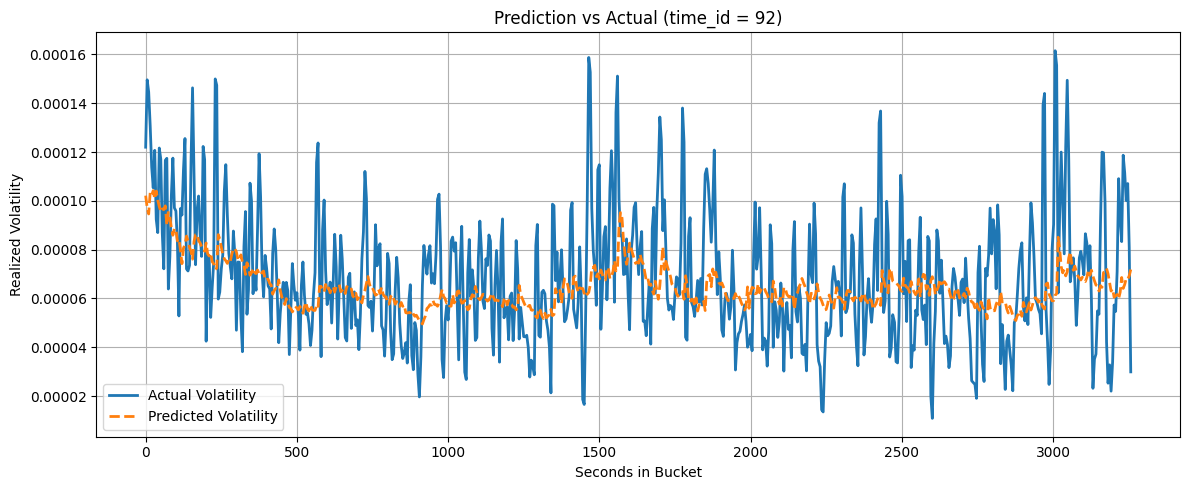

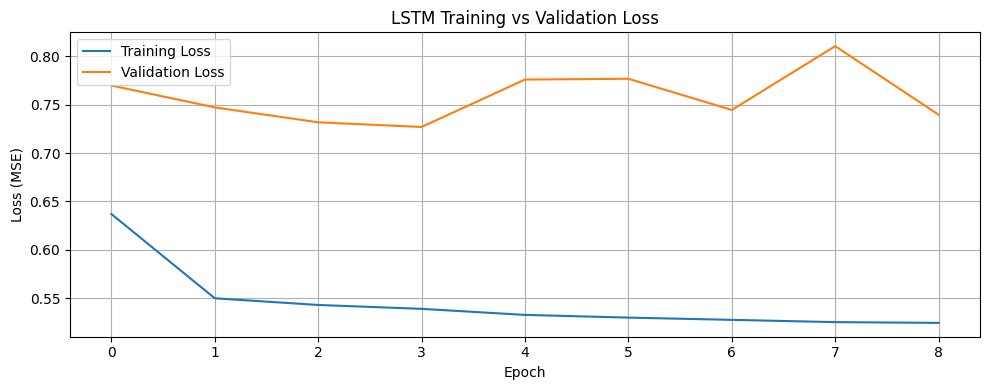

In [11]:
util.plot_prediction_vs_actual(
    df=test_df_lstm_v256d03,
    time_id=test_df_lstm_v256d03['time_id'].iloc[1],
    y_true_col="y_true",
    y_pred_col="y_pred"
)

util.plot_training_loss(history_lstm_v256d03)

In [ ]:
snapshot_more_feature_df = util.add_features(snapshot_features_df)
feature_cols = ["wap", "spread_pct", "imbalance", "depth_ratio", "log_return",
                "log_wap_change", "rolling_std_logret", "spread_zscore", "volume_imbalance"]


subset_time_ids = snapshot_more_feature_df['time_id'].unique()[:400]
df_subset = snapshot_more_feature_df[snapshot_more_feature_df['time_id'].isin(subset_time_ids)].copy()
lstm_df_more_feature = util.generate_tick_sequences(df_subset, feature_cols)

In [13]:
model_lstm_more_feature, history_lstm_more_feature, test_df_lstm_more_feature = lstm.config_v256d03(lstm_df_more_feature)

Epoch 1/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 74s 45ms/step - loss: 0.6046 - val_loss: 0.7826 - learning_rate: 1.0000e-04
Epoch 2/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 73s 45ms/step - loss: 0.5457 - val_loss: 0.8467 - learning_rate: 1.0000e-04
Epoch 3/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 73s 45ms/step - loss: 0.5440 - val_loss: 0.7888 - learning_rate: 1.0000e-04
Epoch 4/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 73s 45ms/step - loss: 0.5485 - val_loss: 0.7547 - learning_rate: 1.0000e-04
Epoch 5/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 74s 45ms/step - loss: 0.5233 - val_loss: 0.7806 - learning_rate: 1.0000e-04
Epoch 6/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 74s 45ms/step - loss: 0.5087 - val_loss: 0.7708 - learning_rate: 1.0000e-04
Epoch 7/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 76s 47ms/step - loss: 0.5022 - val_loss: 0.7543 - learning_rate: 1.0000e-04
Epoch 8/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 74s 45ms/step - loss: 0.5187 - val_loss: 0.7361 - learning_rate: 1.0000e-04
Epoch 9/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 73s 45ms/step 

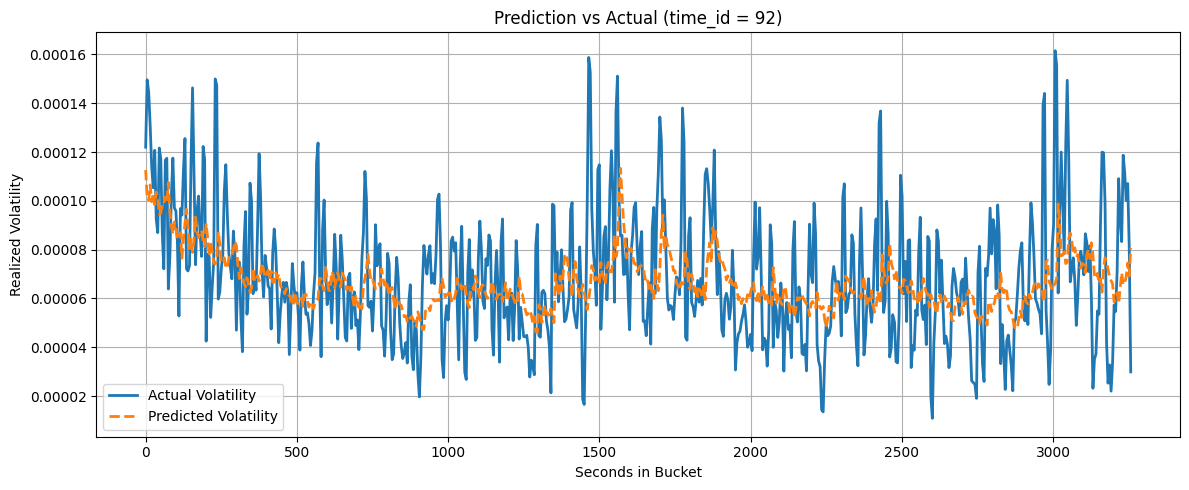

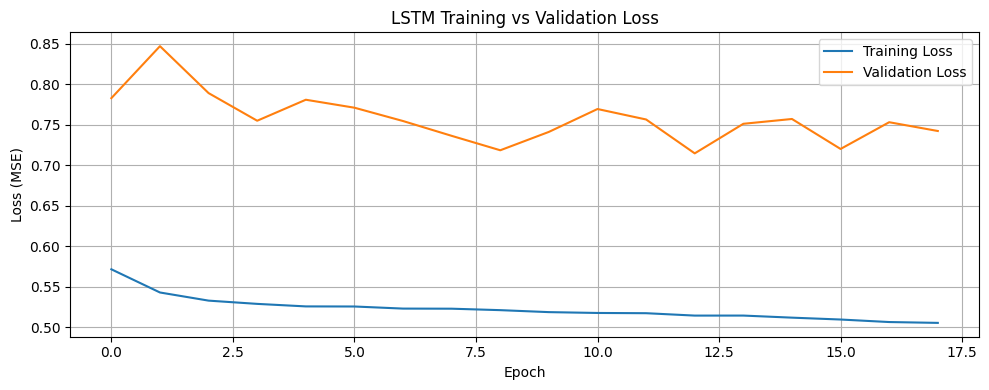

In [14]:
util.plot_prediction_vs_actual(
    df=test_df_lstm_more_feature,
    time_id=test_df_lstm_more_feature['time_id'].iloc[1],
    y_true_col="y_true",
    y_pred_col="y_pred"
)

util.plot_training_loss(history_lstm_more_feature)

In [ ]:
import models.garch as garch
importlib.reload(garch)

selected_ids = rolling_features_df["time_id"].drop_duplicates().sort_values().iloc[:400]

rolling_subset = rolling_features_df[rolling_features_df["time_id"].isin(selected_ids)].reset_index(drop=True)
snapshot_subset = snapshot_features_df[snapshot_features_df["time_id"].isin(selected_ids)].reset_index(drop=True)

print(rolling_subset.keys())
print(snapshot_subset.keys())

Index(['stock_id', 'time_id', 'start_time', 'wap_mean', 'wap_std', 'wap_max',
       'wap_min', 'spread_pct_mean', 'spread_pct_std', 'spread_pct_max',
       'spread_pct_min', 'imbalance_mean', 'imbalance_std', 'imbalance_max',
       'imbalance_min', 'depth_ratio_mean', 'depth_ratio_std',
       'depth_ratio_max', 'depth_ratio_min', 'log_return_mean',
       'log_return_std', 'log_return_max', 'log_return_min',
       'realized_volatility', 'datetime'],
      dtype='object')
Index(['stock_id', 'time_id', 'seconds_in_bucket', 'bid_price1', 'ask_price1',
       'bid_price2', 'ask_price2', 'bid_size1', 'ask_size1', 'bid_size2',
       'ask_size2', 'mid_price', 'wap', 'bid_ask_spread', 'spread_pct',
       'imbalance', 'depth_ratio', 'log_return'],
      dtype='object')


In [99]:
importlib.reload(garch)
model, result_df = garch.baseline(rolling_subset, snapshot_subset)

Running ARMA-GARCH forecast...


Processing:   7%|▋         | 2152/28779 [00:17<03:34, 123.90it/s]/Users/kang/Projects/volatility-analysis/.conda/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Processing: 100%|██████████| 28779/28779 [03:40<00:00, 130.45it/s]

=== ARMA-GARCH Baseline Evaluation (on test set) ===
MSE: 0.00000001
RMSE: 0.00010478
QLIKE: 2.0940
Directional Accuracy: 0.5006
Success Rate: 26145/28779


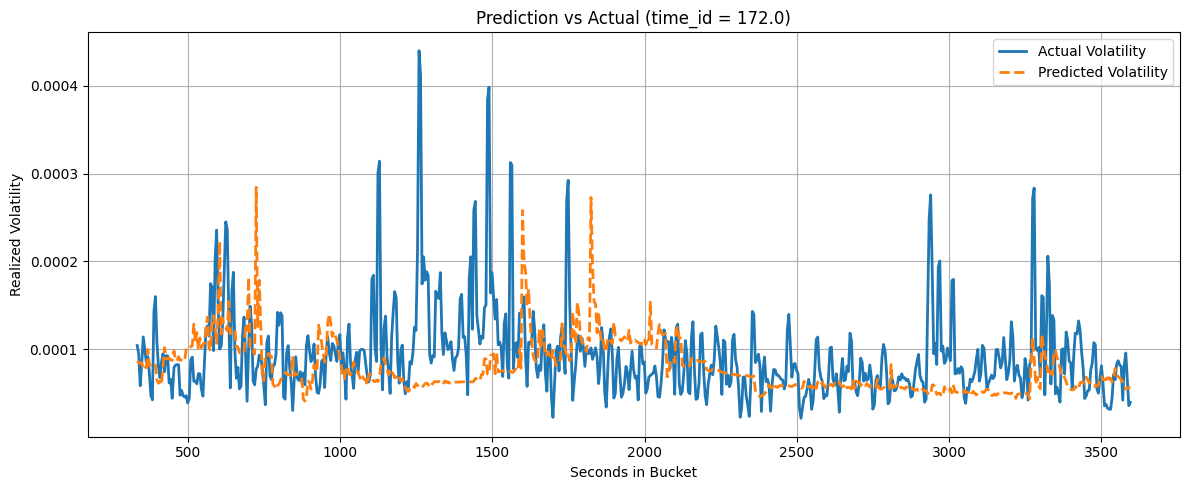

In [101]:
util.plot_prediction_vs_actual(
    df=result_df,
    time_id=result_df['time_id'].iloc[1],
    y_true_col="y_true",
    y_pred_col="y_pred"
)

In [ ]:
importlib.reload(garch)

model_garch_grid, result_df_garch_grid = garch.baseline_grid(
    rolling_df=rolling_subset,
    full_df=snapshot_subset,
    p_values=[1, 2, 3], 
    q_values=[1, 2, 3],
    scale=1000000
)


🔍 Grid search over (p, q) combinations: [(1, 1), (1, 2), (2, 1), (2, 2), (3, 1), (3, 2)]

▶ Evaluating GARCH(1,1)


GARCH(1,1): 100%|██████████| 14392/14392 [01:46<00:00, 134.89it/s]


    → RMSE = 0.00021417, QLIKE = 3.5359, Directional Accuracy = 0.5025

▶ Evaluating GARCH(1,2)


GARCH(1,2): 100%|██████████| 14392/14392 [02:25<00:00, 98.79it/s] 


    → RMSE = 0.00021420, QLIKE = 3.5362, Directional Accuracy = 0.5064

▶ Evaluating GARCH(2,1)


GARCH(2,1): 100%|██████████| 14392/14392 [02:13<00:00, 107.55it/s]


    → RMSE = 0.00021417, QLIKE = 3.5353, Directional Accuracy = 0.5034

▶ Evaluating GARCH(2,2)


GARCH(2,2):  31%|███       | 4472/14392 [00:53<01:44, 94.82it/s] /Users/kang/Projects/volatility-analysis/.conda/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
GARCH(2,2):  80%|███████▉  | 11477/14392 [02:27<00:48, 60.49it/s] /Users/kang/Projects/volatility-analysis/.conda/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
GARCH(2,2):  80%|███████▉  | 11490/14392 [02:27<00:56, 51.26it/s]/Users/kang/Projects/volatility-analysis/.conda/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for c

    → RMSE = 0.00021419, QLIKE = 3.5354, Directional Accuracy = 0.5044

▶ Evaluating GARCH(3,1)


GARCH(3,1): 100%|██████████| 14392/14392 [02:45<00:00, 87.02it/s] 


    → RMSE = 0.00021417, QLIKE = 3.5355, Directional Accuracy = 0.5051

▶ Evaluating GARCH(3,2)


GARCH(3,2):  10%|▉         | 1432/14392 [00:20<03:30, 61.47it/s]/Users/kang/Projects/volatility-analysis/.conda/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
GARCH(3,2):  23%|██▎       | 3328/14392 [00:48<02:56, 62.60it/s] /Users/kang/Projects/volatility-analysis/.conda/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
GARCH(3,2):  41%|████      | 5882/14392 [01:25<01:20, 105.19it/s]/Users/kang/Projects/volatility-analysis/.conda/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.

    → RMSE = 0.00021416, QLIKE = 3.5350, Directional Accuracy = 0.5065

✅ Grid Search Complete. Best Model Summary:
                           AR - GARCH Model Results                           
Dep. Variable:                      y   R-squared:                      -0.006
Mean Model:                        AR   Adj. R-squared:                 -0.010
Vol Model:                      GARCH   Log-Likelihood:               -1812.09
Distribution:                  Normal   AIC:                           3640.19
Method:            Maximum Likelihood   BIC:                           3670.56
                                        No. Observations:                  329
Date:                Mon, May 12 2025   Df Residuals:                      327
Time:                        00:22:52   Df Model:                            2
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------

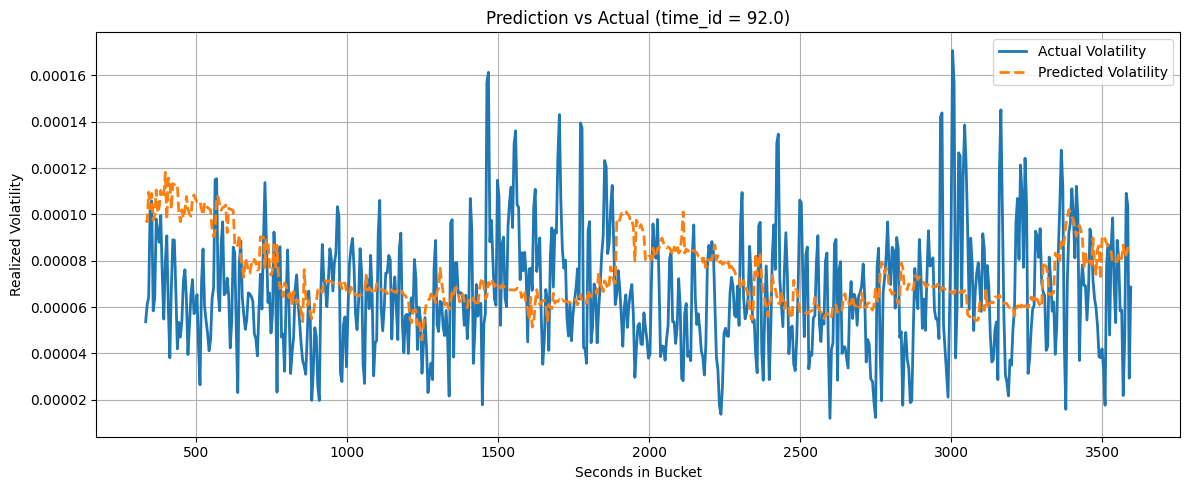

In [72]:
util.plot_prediction_vs_actual(
    df=result_df_garch_grid,
    time_id=result_df_garch_grid['time_id'].iloc[1],
    y_true_col="y_true",
    y_pred_col="y_pred"
)